[[2896.4001   1810.25     1810.25     ... 2005.25     2005.25
  3362.6504  ]
 [1726.7002    -27.850052  -27.850052 ...  -30.850006  -30.850006
  2036.1001  ]
 [1720.25      -37.60005   -37.60005  ...  -34.100006  -34.100006
  2034.1001  ]
 ...
 [1946.8003    -31.399933  -31.399933 ...  -18.39986   -16.999989
   907.95    ]
 [1946.8003    -31.399933  -31.399933 ...  -47.79995   -30.099993
   898.3     ]
 [3297.       2009.6      2009.6      ...  831.90015   807.7501
  1390.4001  ]]
Input shape: (480, 640, 3), Output shape: (480, 640)


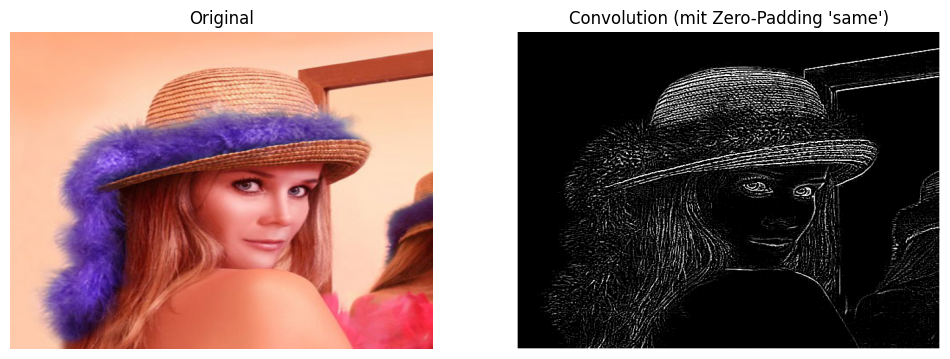

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def conv2d_rgb(image, kernel_3d):
    h, w, c = image.shape
    k_h, k_w, k_c = kernel_3d.shape
    assert c == k_c, "Kernel depth muss gleich Channelzahl sein!"

    # ÄNDERUNG: Die Output-Größe ist bei 'same' padding gleich der Input-Größe
    out_h = h
    out_w = w
    output = np.zeros((out_h, out_w), dtype=np.float32)

    # echte 2D-Faltung über alle Kanäle
    for ch in range(c):
        # ÄNDERUNG: mode='same' fügt automatisch Zero-Padding hinzu
        output += convolve2d(image[:,:,ch], kernel_3d[:,:,ch], mode='same') 

    return output


WIDTH, HEIGHT = 640, 480

# Bild laden
with open("input_image.dat", "rb") as f:
    raw_data = np.frombuffer(f.read(), dtype=np.uint8)
image = raw_data.reshape((HEIGHT, WIDTH, 3))

# Kernel für 3 Kanäle (gleicher Kantendetektor in allen Kanälen)
base_kernel = np.array([
    [-1.25, -0.90, -1.10],
    [-0.95,  8.30, -0.85],
    [-1.15, -0.95, -1.20]
], dtype=np.float32)

kernel_3d = np.stack([base_kernel]*3, axis=-1)  # Form (3,3,3)

# Faltung
conv_result = conv2d_rgb(image, kernel_3d)
print(conv_result)
print(f"Input shape: {image.shape}, Output shape: {conv_result.shape}") # Zur Kontrolle

# Normierung für Anzeige
conv_img = np.clip(conv_result, 0, 255).astype(np.uint8)

# Plot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(image)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Convolution (mit Zero-Padding 'same')")
plt.imshow(conv_img, cmap="gray")
plt.axis("off")
plt.show()

[2896.4067  1810.25    1810.25    ...  831.90326  831.90326  831.90326]


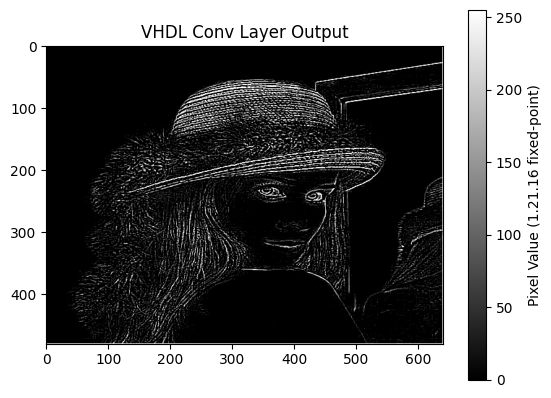

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def read_dat_image_fixed38(dat_filename, width, height):
    """
    Liest eine .dat Datei mit 38-bit Festkommawerten (1.21.16) pro Pixel ein.
    Annahme: Jeder Wert ist in 5 Bytes (40 Bit) gespeichert, die oberen 2 Bits ungenutzt.
    Ergebnis: NumPy-Array (height, width) mit float-Werten.
    """
    bytes_per_pixel = 5
    expected_size = width * height * bytes_per_pixel

    with open(dat_filename, "rb") as f:
        raw_data = f.read()

    if len(raw_data) != expected_size:
        raise ValueError(f"Dateigröße passt nicht zum Bildformat: erwartet {expected_size} Bytes, Datei hat {len(raw_data)} Bytes")

    # In NumPy Array laden (5 Bytes pro Pixel)
    arr = np.frombuffer(raw_data, dtype=np.uint8).reshape(-1, bytes_per_pixel)

    def bytes_to_fixed38(b):
        # 5 Bytes zu 40 Bit zusammensetzen
        val = 0
        for byte in b:
            val = (val << 8) | int(byte)
        # nur die unteren 38 Bit gültig
        val &= (1 << 38) - 1
        # Vorzeichen prüfen (Bit 37)
        if val & (1 << 37):
            val -= 1 << 38
        # Nachkommaanteil (16 Bits)
        return val / (1 << 16)

    pixels = np.array([bytes_to_fixed38(px) for px in arr], dtype=np.float32)
    print(pixels)
    pixels = np.clip(pixels, 0, 255).astype(np.uint8)
    img = pixels.reshape((height, width))
    return img

width, height = 640, 480   # deine Werte
img = read_dat_image_fixed38("output_image_Conv_layer.dat", width, height)

plt.imshow(img, cmap="gray")
plt.colorbar(label="Pixel Value (1.21.16 fixed-point)")
plt.title("VHDL Conv Layer Output")
plt.show()

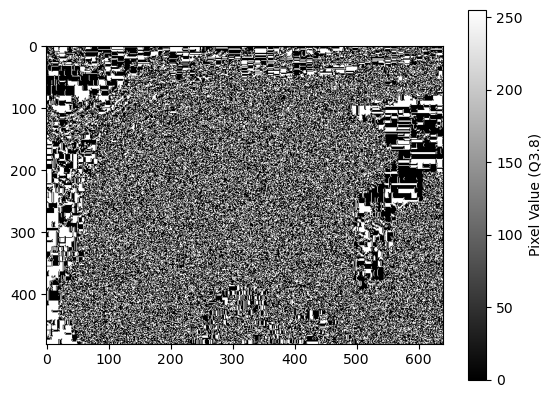

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def bytes_to_fixed38(b):
    """Wandelt 5 Byte (40 Bit signed Fixed3.8) in float um"""
    assert len(b) == 5
    val = int.from_bytes(b, byteorder="little", signed=True)  # 40-bit signed
    return val / (2**8)  # weil Q3.8 → 8 Fraction-Bits

def read_dat_image_fixed38(dat_filename, width, height):
    with open(dat_filename, "rb") as f:
        data = f.read()

    # 5-Byte-Chunks
    arr = [data[i:i+5] for i in range(0, len(data), 5)]

    # In Pixelwerte umwandeln
    pixels = np.array([bytes_to_fixed38(px) for px in arr], dtype=np.float32)

    # Auf gewünschte Größe bringen (falls Abweichungen)
    total_px = width * height
    if pixels.size < total_px:
        pad = total_px - pixels.size
        pixels = np.pad(pixels, (0, pad), mode="constant")
    elif pixels.size > total_px:
        pixels = pixels[:total_px]

    # Clipping für Bilddarstellung
    pixels = np.clip(pixels, 0, 255).astype(np.uint8)
    img = pixels.reshape((height, width))
    return img


# Test
width, height = 640, 480
img = read_dat_image_fixed38("output_image_Conv_layer_ones.dat", width, height)

plt.imshow(img, cmap="gray")
plt.colorbar(label="Pixel Value (Q3.8)")
plt.show()


In [70]:
with open("output_image_Conv_layer_ones.dat", "rb") as f:
    data = f.read()

print("Dateigröße (Bytes):", len(data))
print("Erwartet (480x640 Pixel, 5 Byte pro Pixel?):", 480*640*5)
print("Erwartet (480x640 Pixel, 4 Byte pro Pixel?):", 480*640*4)
print("Erwartet (480x640 Pixel, 2 Byte pro Pixel?):", 480*640*2)


Dateigröße (Bytes): 1536000
Erwartet (480x640 Pixel, 5 Byte pro Pixel?): 1536000
Erwartet (480x640 Pixel, 4 Byte pro Pixel?): 1228800
Erwartet (480x640 Pixel, 2 Byte pro Pixel?): 614400


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def compare_images(img1, img2, normalize=False):
    """
    Vergleicht zwei Graustufenbilder (NumPy-Arrays).

    Parameter:
        img1, img2 : np.ndarray
            Graustufenbilder gleicher Größe.
        normalize : bool
            Ob die Differenz auf 0-255 normalisiert werden soll für die Anzeige.

    Gibt aus:
        - Visuelle Differenz
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Maximum Error
    """
    if img1.shape != img2.shape:
        raise ValueError("Bilder müssen die gleiche Form haben!")

    # Differenz berechnen
    diff = img1.astype(np.float32) - img2.astype(np.float32)

    # Fehlermaße
    mae = np.mean(np.abs(diff))
    mse = np.mean(diff**2)
    max_err = np.max(np.abs(diff))

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Maximum Error: {max_err:.4f}")

    # Optional Normalisierung für Display
    if normalize:
        diff_disp = diff - diff.min()
        diff_disp = diff_disp / diff_disp.max() * 255
        diff_disp = diff_disp.astype(np.uint8)
    else:
        diff_disp = diff

    # Anzeige
    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.title("Image 1")
    plt.imshow(img1, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Image 2")
    plt.imshow(img2, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Difference")
    plt.imshow(diff_disp, cmap="gray")
    plt.colorbar()
    plt.axis("off")
    plt.savefig("vergleich_plot.png", dpi=150)
    plt.show()

    

    return mae, mse, max_err


Mean Absolute Error (MAE): 0.0013
Mean Squared Error (MSE): 0.0013
Maximum Error: 1.0000


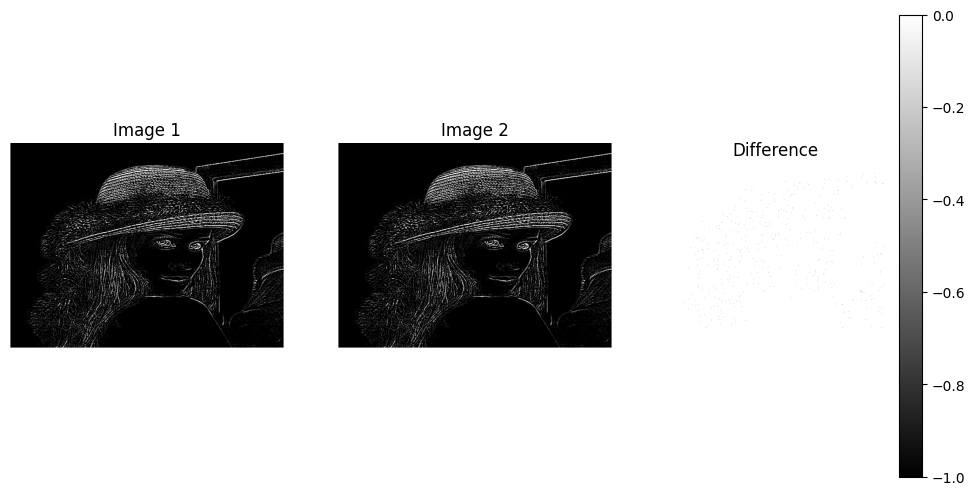

(0.001328125, 0.001328125, 1.0)

In [5]:
compare_images(conv_img, img, normalize=False)

In [39]:
conv_img.shape

(480, 640)

In [37]:
img.shape

(480, 640)

In [112]:
import numpy as np

# ====== Parameter ======
TOTAL_BITS = 25
FRAC_BITS = 16
FRAC_BITS_IN = 0
MAX_KERNEL_VALUE = 4
ADD_WIDTH = TOTAL_BITS + MAX_KERNEL_VALUE

# ====== Hilfsfunktionen ======
def to_signed(val, bits):
    if isinstance(val, str):
        val = int(val, 2)
    if val & (1 << (bits - 1)):
        val -= 1 << bits
    return val

def to_bin(value, bits):
    return format(value & ((1 << bits) - 1), f"0{bits}b")

def to_hex(value, bits):
    return format(value & ((1 << bits) - 1), f"0{bits//4}X")

def mult_signed_festkomma(pixel_val_hex, kernel_val_bin):
    """Simuliert deine VHDL-Funktion mult_signed_festkomma"""
    pixel_val = int(pixel_val_hex, 16)
    kernel_val = to_signed(kernel_val_bin, TOTAL_BITS)

    # Pixel in Q-Format umwandeln (Shift)
    pixel_q = pixel_val << (FRAC_BITS - FRAC_BITS_IN)

    # Multiplikation
    product = pixel_q * kernel_val

    # Runden (+0.5 LSB)
    product_rounded = product + (1 << (FRAC_BITS - 1))

    # Slice -> Ergebnisbreite wie in VHDL
    result = product_rounded >> (FRAC_BITS)

    # Begrenzen auf Zielbreite (ADD_WIDTH)
    result &= (1 << ADD_WIDTH) - 1
    if result & (1 << (ADD_WIDTH - 1)):
        result -= 1 << ADD_WIDTH

    return result

# ====== Eingabedaten ======
kernel = [
    (
        "1111111101100000000000000","1111111110001100110011010","1111111101110011001100110",
        "1111111110000110011001101","0000010000100110011001101","1111111110010011001100110",
        "1111111101101100110011010","1111111110000110011001101","1111111101100110011001101"
    ),
    (
        "1111111101100000000000000","1111111110001100110011010","1111111101110011001100110",
        "1111111110000110011001101","0000010000100110011001101","1111111110010011001100110",
        "1111111101101100110011010","1111111110000110011001101","1111111101100110011001101"
    ),
    (
        "1111111101100000000000000","1111111110001100110011010","1111111101110011001100110",
        "1111111110000110011001101","0000010000100110011001101","1111111110010011001100110",
        "1111111101101100110011010","1111111110000110011001101","1111111101100110011001101"
    )
]

window = [
    ["AB"]*9,
    ["CA"]*9,
    ["FF"]*9
]

expected = [
    (
        "111001010100100000000000000","111011001100001100111011110","111010000111110011000100010",
        "111010111011000110011101111","101100010110100110011101111","111011011101010011000100010",
        "111001110110101100111011110","111010111011000110011101111","111001100101100110011101111"
    ),
    (
        "111000000111000000000000000","111010010100011001110000100","111001000011100110001111100",
        "111010000000001100111000010","110100011001001100111000010","111010101000100110001111100",
        "111000101111011001110000100","111010000000001100111000010","111000011011001100111000010"
    ),
    (
        "110110000010100000000000000","111000110101000000001100110","110111001110111111110011010",
        "111000011011100000000110011","000010001001000000000110011","111001001110011111110011010",
        "110110110101100000001100110","111000011011100000000110011","110110011100000000000110011"
    )
]

# ====== Vergleich ======
for ch in range(3):
    print(f"\n--- Kanal {ch} ---")
    print(f"{'Idx':<3} | {'Win(hex)':<8} | {'Ker(bin)':<27} | {'Result(bin)':<27} | {'Exp(bin)':<27} | Match")
    print("-"*110)

    for i in range(9):
        res = mult_signed_festkomma(window[ch][i], kernel[ch][i])
        exp = to_signed(expected[ch][i], ADD_WIDTH)
        res_bin = to_bin(res, ADD_WIDTH)
        match = "✅" if res == exp else "❌"
        print(f"{i:<3} | {window[ch][i]:<8} | {kernel[ch][i]:<27} | {res_bin:<27} | {expected[ch][i]:<27} | {match}")



--- Kanal 0 ---
Idx | Win(hex) | Ker(bin)                    | Result(bin)                 | Exp(bin)                    | Match
--------------------------------------------------------------------------------------------------------------
0   | AB       | 1111111101100000000000000   | 11111001010100100000000000000 | 111001010100100000000000000 | ❌
1   | AB       | 1111111110001100110011010   | 11111011001100001100111011110 | 111011001100001100111011110 | ❌
2   | AB       | 1111111101110011001100110   | 11111010000111110011000100010 | 111010000111110011000100010 | ❌
3   | AB       | 1111111110000110011001101   | 11111010111011000110011101111 | 111010111011000110011101111 | ❌
4   | AB       | 0000010000100110011001101   | 00101100010110100110011101111 | 101100010110100110011101111 | ✅
5   | AB       | 1111111110010011001100110   | 11111011011101010011000100010 | 111011011101010011000100010 | ❌
6   | AB       | 1111111101101100110011010   | 11111001110110101100111011110 | 11100111011010

In [116]:
def bin_to_signed_int(b: str) -> int:
    """Wandelt eine Binär-Zahl im Zweierkomplement in eine signed Integer um."""
    n = len(b)
    val = int(b, 2)
    if b[0] == '1':  # negatives Vorzeichen
        val -= 1 << n
    return val

def compare_scaled(calc_bin, exp_bin, max_shift=5):
    """Vergleicht zwei Binärwerte unter Berücksichtigung möglicher Bit-Shift-Skalierungen."""
    calc = bin_to_signed_int(calc_bin)
    exp = bin_to_signed_int(exp_bin)
    
    for shift in range(-max_shift, max_shift + 1):
        scaled = calc >> shift if shift >= 0 else calc << abs(shift)
        if scaled == exp:
            return True, shift
    return False, None


# Beispiel-Daten:
calc_bin = "00101100010110100110011101111"  # dein Python/VHDL-Ergebnis
exp_bin  = "101100010110100110011101111"    # erwarteter Wert

ok, shift = compare_scaled(calc_bin, exp_bin)
if ok:
    print(f"✅ Werte sind gleich – nur um {shift} Bits verschoben")
else:
    print("❌ Werte unterscheiden sich")

# Optional: zur Kontrolle die Dezimalwerte ausgeben
print(f"calc = {bin_to_signed_int(calc_bin)}")
print(f"exp  = {bin_to_signed_int(exp_bin)}")


❌ Werte unterscheiden sich
calc = 93015279
exp  = -41202449
